In [18]:
%matplotlib inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sotodlib import core
from sotodlib.core.metadata import ManifestDb, load_metadata
import sotodlib.io.load_book as lb

In [19]:
## context for loading data
ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')


In [20]:
start = dt.datetime(2025,3,1, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,5,1, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='oper' and subtype=='iv'"
    " and stream_ids_list == 'ufm_mv34'"
)
obs_list

ResultSet<[obs_id,timestamp,start_time,stop_time,n_samples,telescope,telescope_flavor,tube_slot,tube_flavor,type,subtype,wafer_count,detector_flavor,duration,az_center,az_throw,el_center,el_throw,roll_center,roll_throw,wafer_slots_list,stream_ids_list], 78 rows>

In [21]:
fields = [
    'p_sat', 'R_n', 'bgmap'
]
def add_iv_info( meta ):
    iv = core.AxisManager( meta.dets )

    for f in fields:
        iv.wrap_new(f, ('dets',))
        iv[f] *= np.nan
    iv_data = lb.load_smurf_npy_data(ctx, meta.obs_info.obs_id, 'iv')

    for d in range( iv_data['nchans']):
        idx = np.where( np.all( [
            meta.det_info.smurf.band == iv_data['bands'][d],
            meta.det_info.smurf.channel == iv_data['channels'][d],
        ], axis=0))[0]
        if len(idx) == 0:
            print( f"Cannot find ({iv_data['bands'][d]},{iv_data['channels'][d]})")
            continue
        idx = idx[0]
        iv.bgmap[idx] = iv_data['bgmap'][d]
        
        if iv.bgmap[idx] not in iv_data['bias_groups']:
            ## iv did not include bias group detector is attached to
            continue
        
        iv.p_sat[idx] = iv_data['p_sat'][d]*1e12
        iv.R_n[idx] = iv_data['R_n'][d]
    meta.wrap("iv", iv)

In [22]:
obs = obs_list[50]

meta = ctx.get_meta( obs )
add_iv_info( meta )


(array([  0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   5.,  13.,
         30.,  34.,  60., 135., 274.,  70.,   8.,   4.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
        5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <BarContainer object of 20 artists>)

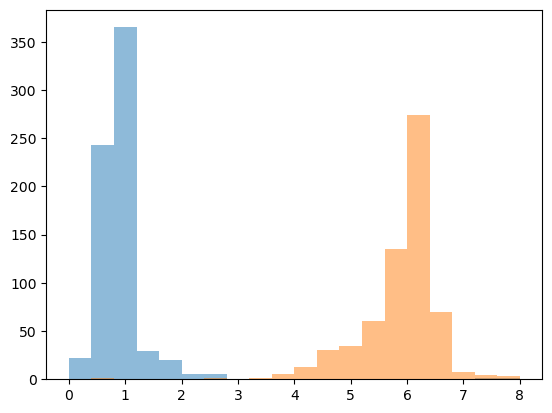

In [23]:
plt.figure()
msk_f090 = np.any([meta.iv.bgmap == x for x in [0,1,4,5,8,9]],axis=0)
msk_f150 = np.any([meta.iv.bgmap == x for x in [2,3,6,7,10,11]],axis=0)

plt.hist( meta.iv.p_sat[msk_f090], range=(0,8), bins=20, alpha=0.5,)
plt.hist( meta.iv.p_sat[msk_f150], range=(0,8), bins=20, alpha=0.5,)


In [24]:
## from above, I know obs_list has only one stream_id in it

singles = []
for i in range(30,70):
    obs = obs_list[i]
    meta = ctx.get_meta( obs )
    add_iv_info( meta )
    singles.append(meta)
x = [m.dets.count for m in singles]
assert min(x) == max(x), "Need to add some additional checks if channel counts are changing"

In [92]:
all_iv_data = core.AxisManager(
    singles[0].dets,
    core.IndexAxis('obs', len(singles)),
)

obs_info = core.AxisManager(all_iv_data.obs)
for f in singles[0].obs_info._fields.keys():
    obs_info.wrap_new( f, ('obs',), dtype=type(singles[0].obs_info[f]))
for m, meta in enumerate(singles):
    for f in singles[0].obs_info._fields.keys():
        print(meta.obs_info[f])
        obs_info[f][m] = meta.obs_info[f]
print(obs_info.obs_id)

all_iv_data.wrap('obs_info', obs_info)
all_iv_data.wrap('det_info', singles[0].det_info)
# don't have a focal plane yet
#all_iv_data.wrap('focal_plane', singles[0].focal_plane)

iv_data = core.AxisManager( all_iv_data.dets, all_iv_data.obs)
for f in singles[0].iv._fields.keys():
    iv_data.wrap_new(f, ('dets','obs'), dtype=type(singles[0].iv[f]))
    iv_data[f] *= np.nan

for m, meta in enumerate(singles):
    for f in singles[0].iv._fields.keys():
        iv_data[f][:,m] = meta.iv[f][:]
all_iv_data.wrap('iv', iv_data)

oper_1742420863_lati3_001
1742420862.2522166
1742420862.2522166
1742421290.5922167
85669
lat
lat
i3
mf
oper
iv
1
None
428.3400001525879
34.702
0.0001
35.0
0.0001
-24.1572
0.0001
ws2
ufm_mv34
oper_1742423337_lati3_001
1742423336.8122168
1742423336.8122168
1742423769.2372167
86486
lat
lat
i3
mf
oper
iv
1
None
432.4249999523163
24.823
0.0001
40.0
0.0001
-19.1574
0.0001
ws2
ufm_mv34
oper_1742426959_lati3_001
1742426959.7122166
1742426959.7122166
1742427388.4872167
85756
lat
lat
i3
mf
oper
iv
1
None
428.77500009536743
75.261
0.0
30.0
0.0
-29.1571
0.0001
ws2
ufm_mv34
oper_1742433892_lati3_001
1742433890.3672166
1742433890.3672166
1742434317.4522166
85418
lat
lat
i3
mf
oper
iv
1
None
427.085000038147
-136.02
0.0
40.0
0.0
-19.1562
0.0001
ws2
ufm_mv34
oper_1742436087_lati3_001
1742436086.8322167
1742436086.8322167
1742436515.7272167
85780
lat
lat
i3
mf
oper
iv
1
None
428.8949999809265
44.208
0.0
60.0
0.0
0.8438
0.0001
ws2
ufm_mv34
oper_1742438657_lati3_001
1742438655.4272168
1742438655.4272168


AxisManager(obs_info*[obs], det_info*[dets], iv*[dets,obs], dets:LabelAxis(1647), obs:IndexAxis(40))

(0.0, 10.0)

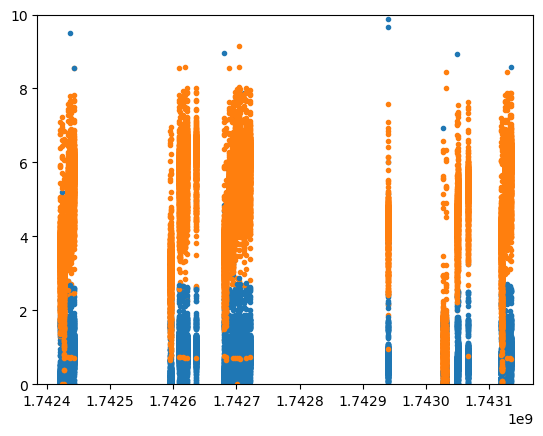

In [26]:
msk_f090 = np.any([meta.iv.bgmap == x for x in [0,1,4,5,8,9]],axis=0)

plt.figure()
for i in range(all_iv_data.dets.count):
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        color='C0'
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        color='C1'
    else:
        continue
    plt.plot( all_iv_data.obs_info.timestamp, all_iv_data.iv.p_sat[i], '.', color=color)

plt.ylim(0,10)

Text(0, 0.5, 'P_sat (pW)')

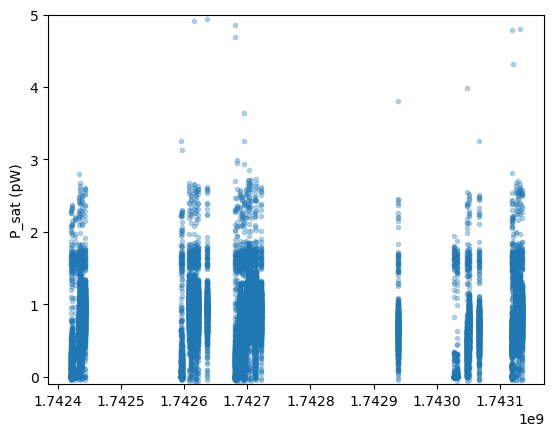

In [27]:
plt.figure()
for i in range(all_iv_data.dets.count):
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        color='C0'
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        continue
    else:
        continue
    plt.plot( all_iv_data.obs_info.timestamp, all_iv_data.iv.p_sat[i], '.', color=color, alpha=0.3)

plt.ylim(-0.1,5)
plt.ylabel('P_sat (pW)')

In [38]:
all_iv_data.iv.p_sat[:,0].shape

(1647,)

In [82]:
import so3g

pwv = np.zeros(all_iv_data.obs.count)

for i in range(all_iv_data.obs.count):
    try:
        data = so3g.hk.load_range(
                float(all_iv_data.obs_info.start_time[i]), 
                float(all_iv_data.obs_info.stop_time[i]),
                fields = ['site.env-radiometer-class.feeds.pwvs.pwv'],
                alias = ['pwv'],
                data_dir='/so/level2-daq/site/hk/'
        )
        pwv[i] = np.mean(data['pwv'][1])
    except KeyError:
        pwv[i] = np.nan

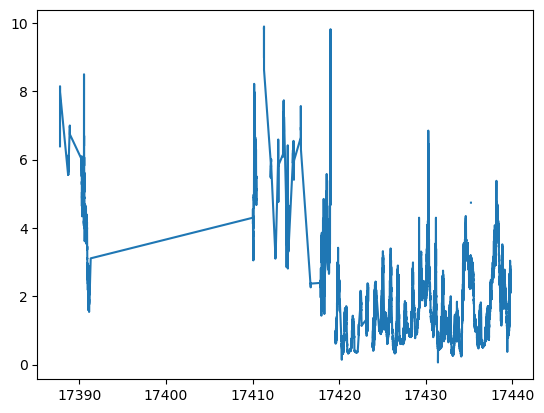

In [98]:
import numpy as np
import matplotlib.pyplot as plt

filepath = 'apex_pwv_data.npz'
data = {}
with np.load(filepath, allow_pickle=True) as x:
    for k in x.keys():
        data[k] = x[k]

plt.figure()
plt.plot(data['timestamp']/1e5, data['pwv'])
plt.savefig('pwv_history')

In [96]:
np.amax(data["timestamp"])

1701685560.0

In [97]:
all_iv_data.obs_info.start_time

array([1.74242086e+09, 1.74242334e+09, 1.74242696e+09, 1.74243389e+09,
       1.74243609e+09, 1.74243866e+09, 1.74244274e+09, 1.74259461e+09,
       1.74259666e+09, 1.74260855e+09, 1.74261114e+09, 1.74261503e+09,
       1.74261875e+09, 1.74262167e+09, 1.74263586e+09, 1.74268113e+09,
       1.74268309e+09, 1.74268823e+09, 1.74269236e+09, 1.74269524e+09,
       1.74269762e+09, 1.74270085e+09, 1.74270329e+09, 1.74270628e+09,
       1.74271235e+09, 1.74271437e+09, 1.74272224e+09, 1.74293926e+09,
       1.74302716e+09, 1.74303230e+09, 1.74304837e+09, 1.74305092e+09,
       1.74306647e+09, 1.74311845e+09, 1.74311951e+09, 1.74312058e+09,
       1.74312552e+09, 1.74312811e+09, 1.74313237e+09, 1.74313436e+09])